In [2]:
import modeller, fitter, ingestor, casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

In [3]:
context = ingestor.Context("runs/passivefull3.3.run")

In [4]:
solver = fitter.Fitter(context)

In [5]:
objective = solver.inner_objectives[0].inner_criterion

In [8]:
objective

MX(@1=t[0], @2=t[1], @3=t[2], @4=t[3], @5=t[4], @6=t[5], @7=t[6], @8=t[7], @9=t[8], @10=t[9], @11=t[10], @12=t[11], @13=t[12], @14=t[13], @15=t[14], @16=t[15], @17=t[16], @18=t[17], @19=t[18], @20=t[19], @21=t[20], @22=t[21], @23=t[22], @24=t[23], @25=t[24], @26=t[25], @27=t[26], @28=t[27], @29=t[28], @30=t[29], @31=t[30], @32=t[31], @33=t[32], @34=t[33], @35=t[34], @36=t[35], @37=t[36], @38=t[37], @39=t[38], @40=t[39], @41=t[40], @42=t[41], @43=t[42], @44=t[43], @45=t[44], @46=t[45], @47=t[46], @48=t[47], @49=t[48], @50=t[0], @51=t[1], @52=t[2], @53=t[3], @54=t[4], @55=t[5], @56=t[6], @57=t[7], @58=t[8], @59=t[9], @60=t[10], @61=t[11], @62=t[12], @63=t[13], @64=t[14], @65=t[15], @66=t[16], @67=t[17], @68=t[18], @69=t[19], @70=t[20], @71=t[21], @72=t[22], @73=t[23], @74=t[24], @75=t[25], @76=t[26], @77=t[27], @78=t[28], @79=t[29], @80=t[30], @81=t[31], @82=t[32], @83=t[33], @84=t[34], @85=t[35], @86=t[36], @87=t[37], @88=t[38], @89=t[39], @90=t[40], @91=t[41], @92=t[42], @93=t[43], @94

In [16]:
print(solver.inner_objectives[0].input_list)
print([x.size() for x in solver.inner_objectives[0].input_list])

[MX(t), MX(c_0), MX(c_1), MX(c_2), MX(p_0), MX(p_1), MX(p_2), MX(p_3), MX(p_4), MX(p_5), MX(p_6), MX(p_7), MX(p_8), MX(p_9), MX(p_10), MX(p_11), MX(p_12), MX(H0), MX(H1), MX(H2), MX(y_0), MX(y_1), MX(y_2), MX(rho)]
[(49, 1), (13, 1), (13, 1), (13, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (19, 49), (19, 49), (19, 49), (19, 1), (19, 1), (19, 1), (1, 1)]


In [15]:
def fill_objective(inner_objective, dataset, model):
    il  = inner_objective.input_list
    objfn = inner_objective.inner_criterion
    obsvhs = inner_objective.generate_collocation_matrix(dataset, model)
    ys = list(inner_objective.pad_observations(dataset['y']))
    objfn = ca.substitute([objfn], il[-7:-4], obsvhs)[0]
    objfn = ca.substitute(objfn, il[0], model.observation_times)
    objfn = ca.substitute([objfn], il[-4:-1], ys)[0]
    return objfn
    

opts = {
    'x':ca.vcat(solver.inner_objectives[0].input_list[1:17]),
    'p':solver.inner_objectives[0].input_list[-1],
    'f':fill_objective(solver.inner_objectives[0], context.datasets[0], solver.models[0],)
}

s = ca.nlpsol('s', 'ipopt', opts)

In [39]:
exiter = s(x0=np.random.rand(52, 1), p=1e-5)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1205

Total number of variables............................:       52
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

In [43]:
cs = np.array(exiter['x'][13:])

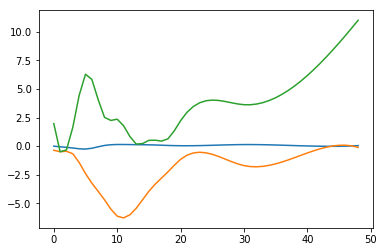

In [44]:
getx = ca.Function("getx", [solver.models[0].ts,
                         *solver.models[0].cs],
                solver.models[0].xs)
xs = np.array([np.array(i) for i in getx(solver.models[0].observation_times, *fitter.argsplit(cs, 3))])
plt.plot(xs.reshape(3, 49).T)